In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt

In [ ]:
# Iniciar una sesión de PySpark
spark = SparkSession.builder.appName("MortgagePrediction").getOrCreate()

In [ ]:
# Cargar los datos
file_path = "/content/drive/My Drive/clean_mortgage_data.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

data=data.orderBy(["YEAR", "MONTH"], ascending=[True, True])
# Mostrar las primeras filas
data.show(5)

+------+---------+--------+--------+-----+-------------+--------------------+------+----+-------+-----+----------+-----------+-----------+--------------+
|SOURCE|FREQUENCY|SERIESID|GEOLEVEL|GEOID|      GEONAME|              MARKET|PERIOD|YEAR|QUARTER|MONTH|SUPPRESSED|MORT_NUMBER|DOLLAR_MEAN|    VOL_DOLLAR|
+------+---------+--------+--------+-----+-------------+--------------------+------+----+-------+-----+----------+-----------+-----------+--------------+
|  NMDB|Quarterly|TOT_ORIG|National|  USA|United States|       All Mortgages|1998Q1|1998|      1|    3|         0|     2544.0|   277368.0|1.411248384E10|
|  NMDB|Quarterly|TOT_ORIG|National|  USA|United States|All Mortgages (Ho...|1998Q1|1998|      1|    3|         0|     1044.0|   108582.0|  2.26719216E9|
|  NMDB|Quarterly|TOT_ORIG|National|  USA|United States|All Mortgages (Re...|1998Q1|1998|      1|    3|         0|     1499.0|   168786.0|  5.06020428E9|
|  NMDB|Quarterly|TOT_ORIG|National|  USA|United States|       All Mortgages

In [ ]:
# Selección de columnas relevantes
columns = ['MARKET', 'YEAR', 'QUARTER', 'MORT_NUMBER', 'DOLLAR_MEAN','VOL_DOLLAR']
data = data.select(*columns)


In [ ]:
# Manejo de valores nulos (si los hay)
data = data.dropna()

# Codificar la columna categórica "MARKET"
indexer = StringIndexer(inputCol="MARKET", outputCol="MARKET_Index")
data = indexer.fit(data).transform(data)


In [ ]:
# Crear un vector de características
assembler = VectorAssembler(
    inputCols=['MARKET_Index', 'YEAR', 'QUARTER'],
    outputCol='features'
)
data = assembler.transform(data)

In [ ]:
# Dividir los datos en entrenamiento y prueba
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Modelo para predecir Loans_NUMBER
lr_loans = LinearRegression(featuresCol='features', labelCol='MORT_NUMBER')
model_loans = lr_loans.fit(train_data)

In [ ]:
# Modelo para predecir Dollar_MEAN
lr_dollar = LinearRegression(featuresCol='features', labelCol='DOLLAR_MEAN')
model_dollar = lr_dollar.fit(train_data)

In [ ]:
# Evaluación del modelo para Loans_Number
predictions_loans = model_loans.transform(test_data)
evaluator = RegressionEvaluator(
    labelCol='MORT_NUMBER',
    predictionCol='prediction',
    metricName='rmse'
)
rmse_loans = evaluator.evaluate(predictions_loans)
print(f"Root Mean Squared Error (RMSE) para MORT_NUMBER: {rmse_loans}")


Root Mean Squared Error (RMSE) para MORT_NUMBER: 109.2445372579781


In [ ]:
# Evaluación del modelo para Dollar_Volume
predictions_dollar = model_dollar.transform(test_data)
evaluator = RegressionEvaluator(
    labelCol='DOLLAR_MEAN',
    predictionCol='prediction',
    metricName='rmse'
)
rmse_dollar = evaluator.evaluate(predictions_dollar)
print(f"Root Mean Squared Error (RMSE) para Dollar_MEAN: {rmse_dollar}")

Root Mean Squared Error (RMSE) para Dollar_Volume: 10668.66540825852


In [ ]:
# Guardar los modelos
model_loans.save("modelo_loans")
model_dollar.save("modelo_dollar")

In [ ]:
def realizar_prediccion(market, year, quarter):
    # Codificar el mercado
    market_index_row = data.filter(data.MARKET == market).select("MARKET_Index").first()
    if market_index_row is None:
        raise ValueError(f"El mercado '{market}' no está presente en los datos originales.")
    market_index = market_index_row["MARKET_Index"]
    # Crear el vector de características
    features = Vectors.dense([market_index, year, quarter])

    # Crear un DataFrame con las características
    input_data = spark.createDataFrame([(features,)], ["features"])

    # Predicción para Loans_Number
    pred_loans = model_loans.transform(input_data).select("prediction").first()[0]

    # Predicción para Dollar_Volume
    pred_dollar = model_dollar.transform(input_data).select("prediction").first()[0]

    return pred_loans, pred_dollar

In [ ]:
# Ejemplo de predicción
market = "Government (Home Purchase)"
year = 2022
quarter = 4
geoname="United States"

pred_loans, pred_dollar = realizar_prediccion(market, year, quarter)
print(f"Predicción para Loans_Number: {pred_loans}")
print(f"Predicción para Dollar_Volume: {pred_dollar}")

ValueError: could not convert string to float: 'United States'

In [ ]:
# Extraer las predicciones y los valores reales
real_loans = predictions_loans.select("MORT_NUMBER").collect()
predicted_loans = predictions_loans.select("prediction").collect()


In [ ]:
real_dollar = predictions_dollar.select("DOLLAR_MEAN").collect()
predicted_dollar = predictions_dollar.select("prediction").collect()

In [ ]:
# Convertir a listas para usar en la gráfica
real_loans_values = [row['MORT_NUMBER'] for row in real_loans]
predicted_loans_values = [row['prediction'] for row in predicted_loans]

real_dollar_values = [row['DOLLAR_MEAN'] for row in real_dollar]
predicted_dollar_values = [row['prediction'] for row in predicted_dollar]

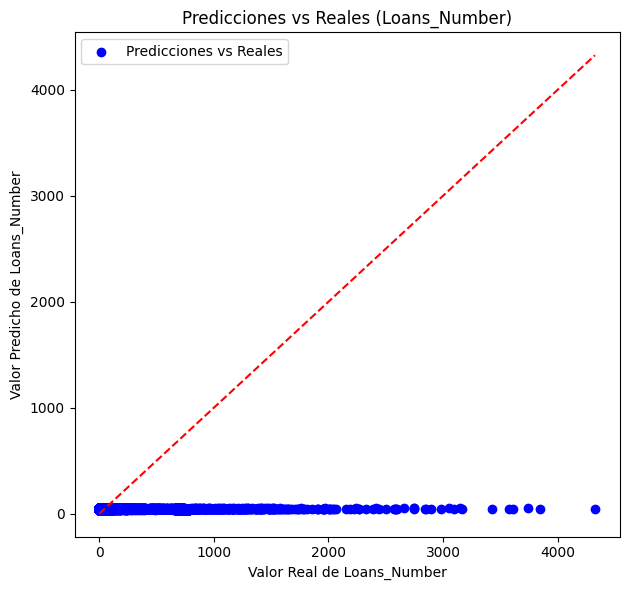

In [ ]:
# Graficar Loans_Number
plt.figure(figsize=(12, 6))
# Subgráfico para Loans_Number
plt.subplot(1, 2, 1)
plt.scatter(real_loans_values, predicted_loans_values, color='blue', label='Predicciones vs Reales')
plt.plot([min(real_loans_values), max(real_loans_values)], [min(real_loans_values), max(real_loans_values)], color='red', linestyle='--')
plt.title('Predicciones vs Reales (Loans_Number)')
plt.xlabel('Valor Real de Loans_Number')
plt.ylabel('Valor Predicho de Loans_Number')
plt.legend()
# Mostrar la gráfica
plt.tight_layout()
plt.show()

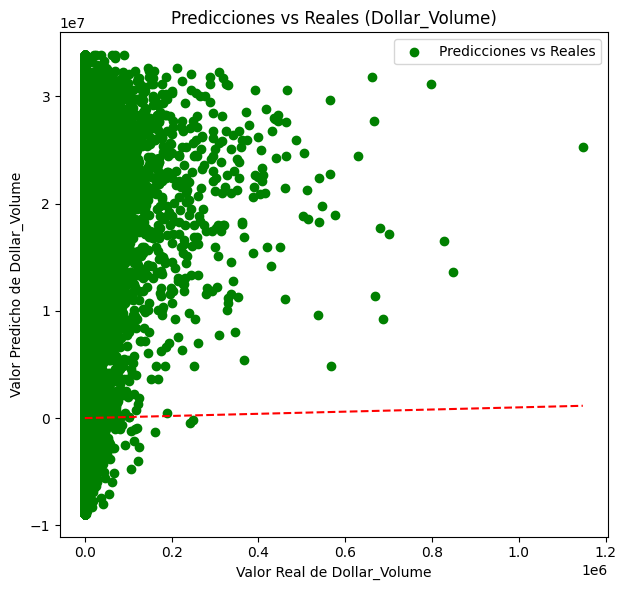

In [ ]:
# Graficar Loans_Number
plt.figure(figsize=(12, 6))
# Graficar Dollar_Volume
plt.subplot(1, 2, 2)
plt.scatter(real_dollar_values, predicted_dollar_values, color='green', label='Predicciones vs Reales')
plt.plot([min(real_dollar_values), max(real_dollar_values)], [min(real_dollar_values), max(real_dollar_values)], color='red', linestyle='--')
plt.title('Predicciones vs Reales (Dollar_Volume)')
plt.xlabel('Valor Real de Dollar_Volume')
plt.ylabel('Valor Predicho de Dollar_Volume')
plt.legend()
# Mostrar la gráfica
plt.tight_layout()
plt.show()